<a href="https://colab.research.google.com/github/erica-mccormick/erica-mccormick.github.io/blob/main/plot_dists_w_sites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make plots with all pixels from given lithologies and specific site data on top

All you have to do to run this is:



1.   Change the 2 path names in the "choose units of interest" section.
2.   Run everything
3.   Use the function at the end to plot away. Notice there are more parameters you can set than I demonstrate, currently.




##**Imports**

In [1]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 19.1MB 26.9MB/s 
     |████████████████████████████████| 1.0MB 11.7MB/s 
     |████████████████████████████████| 6.5MB 51.9MB/s 
     |████████████████████████████████| 15.3MB 292kB/s 


In [2]:
# Certainly don't need some of these..
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['pdf.fonttype'] = 42
from google.colab import files
import seaborn as sns
import rasterio as rio
from rasterio.plot import show
import matplotlib.ticker as ticker
import geopandas
import requests
from rasterio.mask import mask
from rasterio import features
import json
from rasterio.merge import merge
from shapely.geometry import mapping
import glob

%matplotlib inline

In [3]:
#use personal gmail
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Getting lithologies and rasters set up:**

##**Import shapefiles**

In [4]:
### Master path#####
master_path = '/content/drive/MyDrive/ROOTS N ROCK/Rock moisture/RM1b_NatureReview/tiffs/final/'
lithology_path = '/content/drive/MyDrive/ROOTS N ROCK/Rock moisture/RM5_Lithology/Data/'

In [5]:
### Total california lithology
lith = geopandas.read_file(lithology_path +'CAgeol_dd/cageol_poly_dd.shp')
lith[['Name','Extra']] = lith['UNIT_LINK'].str.split(";", expand=True)
lith = lith.to_crs("EPSG:4326")

In [6]:
### Simplified california lithology
#simplified_lith = geopandas.read_file(lithology_path + 'N_CA_Lith/N_CA_Lith.shp')
#simplified_lith.crs
#simplified_lith['Name'].unique()

##**Choose units of interest**



In [7]:
units = pd.DataFrame()
#units['Name'] = ['CATK','CAKJfs','CAKJf1','CAKJfm'] #CAEO 'CAK1'
units['Name'] = ['CATK','CAKJf1','CAKJfm','CAgrMZ2','CAgrMZ3','CAKu1'] #CAEO 'CAK1'

full_df = lith.merge(units, on='Name',how='inner')
full_df.Name.unique()

array(['CAKJf1', 'CAKu1', 'CAgrMZ3', 'CATK', 'CAKJfm', 'CAgrMZ2'],
      dtype=object)

##**Import rasters (not with GEE)**

Find your own path to the 'final' folder within the Nature Review -> Tiffs GoogleDrive folder AND the path to the RM5_Lithology -> Data folder where the shapefile is stored.

In [9]:

# Folders of rasters
dbedrock_path = master_path + 'deficits/dbedrock_no_mask'
dbedrock_files = glob.glob(dbedrock_path + '/*')

p_cum_path = master_path + 'products_used/p_wateryear/*'
p_cum_files = glob.glob(p_cum_path)

p_spring_path =  master_path + 'products_used/p_spring/*'
p_spring_files = glob.glob(p_spring_path)

dmax_path = master_path + 'deficits/dmax_nomask/*'
dmax_files = glob.glob(dmax_path)

pet_path = master_path + 'products_used/pet_modis_annual/*'
pet_files = glob.glob(pet_path)

npp_path = master_path + 'products_used/npp_annual/*'
npp_files = glob.glob(npp_path)

et_summer_path = master_path + 'products_used/et_summer_pml/*'
ett_summer_files = glob.glob(et_summer_path)

## Single rasters - these need to be a 'list' to work with flattened df, which is set up for 'glob' results.
map = [master_path + 'products_used/MAP.tif']
mean_annual_PET = [master_path + 'products_used/mean_annual_pet_modis.tif']
meansnowdays = [master_path + 'results/meanSnowDays2.tif']
biomass = [master_path + 'products_used/biomass.tif']
mean_annual_ET = [master_path + 'products_used/mean_annual_et_pml_wx8.tif']
mask_reproj = [master_path + 'masks/mask_reproj.tif']
mask_ETgtP = [master_path + 'masks/mask_ET_gt_PPT.tif']
mask_shallowBedrock = [master_path + 'masks/mask_shallowBedrock.tif']
mask_woodyveg = [master_path + 'masks/mask_woodyVeg.tif']

#landfire = [master_path + ''] #note this is a 500m landfire, not the og one

#dbedrock_10_nomask = [master_path + 'deficits/dbedrock_no_mask/Dbedrock_2010_nomask.tif']
#dbedrock_median = [master_path +'deficits/bedrock/Dbedrock_median.tif']


##**Rasters -> Dfs**

In [11]:

def get_flat_df(geometry_df, list_of_rasters, column_names):

  final_df = pd.DataFrame()
  temp_df = pd.DataFrame()

  names = geometry_df.Name.unique()

  for j in range(len(names)):
    single_name = geometry_df[geometry_df['Name'] == names[j]]
    geoms = single_name.geometry.values

    for i in range(len(list_of_rasters)):
      with rio.open(list_of_rasters[i]) as src:
        clip, out_transform = mask(src, geoms, filled=True, crop=True, nodata = None)
      
      temp_df[str(column_names[i])] = np.array(clip[0,:,:].flatten())
      temp_df['Name'] = names[j]

    final_df = final_df.append(temp_df)
    temp_df = pd.DataFrame()

  final_df = final_df.reset_index(drop=True)

  return final_df


def get_columnNames(startword):
  year = 2004
  list_of_names = []

  while (year < 2019):
    one_name = startword + str(year)
    list_of_names.append(one_name)
    year += 1

  return list_of_names

In [12]:
# Unmasked Dbedrock for all years, clipped to 0
bedrock_names = get_columnNames('')
bedrock_df =  get_flat_df(full_df, dbedrock_files, bedrock_names)

names_column = bedrock_df['Name'].copy()
bedrock_df = bedrock_df.drop(['Name'], axis=1)
bedrock_df = bedrock_df.clip(lower=0)
bedrock_df['Name'] = names_column
#bedrock_df = bedrock_df.reset_index(drop=True)


In [13]:
# Dmax for all years, clipped to zero
dmax_df = get_flat_df(full_df, dmax_files, bedrock_names)

In [14]:
# cumulative water year precip per year
precip_names = get_columnNames('')
precip_df = get_flat_df(full_df, p_cum_files, precip_names)

In [15]:
# cumulative spring precip per year
precip_spring_names = get_columnNames('')
precip_spring_df = get_flat_df(full_df, p_spring_files, precip_spring_names)
#precip_df = precip_df.reset_index(drop=True)

In [16]:
# cumulative annual PET per year
pet_df = get_flat_df(full_df, pet_files, precip_names)


In [17]:
# summer ET (June, July, Aug)
et_summer_df = get_flat_df(full_df, ett_summer_files, precip_names)

In [18]:
# NPP
npp_df = get_flat_df(full_df, npp_files, precip_names)

In [19]:
# Biomass, MAP, PET, Snow
biomass_df = get_flat_df(full_df, biomass, ['Biomass'])
biomass_df = biomass_df.drop(['Name'], axis=1)
biomass_df = biomass_df.divide(10) #scaling factor
map_df = get_flat_df(full_df, map, ['MAP'])
mapet_df = get_flat_df(full_df, mean_annual_PET, ['PET'])
snow_df = get_flat_df(full_df, meansnowdays, ['Snow'])
maet_df = get_flat_df(full_df,mean_annual_ET, ['MA_ET'])
#landfire_df = get_flat_df(full)df, landfire, ['Landfire'])


In [20]:
mask_df = get_flat_df(full_df, mask_woodyveg, ['Mask'])
mask_df2 = get_flat_df(full_df, mask_ETgtP, ['Mask'])


In [21]:

def getdf(year, extras = False):
  year = str(year)
  bin = pd.DataFrame()

  bin['PET'] = pet_df[year]
  bin['MA_PET'] = mapet_df['PET']
  bin['MAP'] = map_df['MAP']
  bin['MA_ET'] = maet_df['MA_ET']
  bin['P'] = precip_df[year]
  bin['Dmax'] = dmax_df[year]
  bin['Biomass'] = biomass_df['Biomass']
  bin['Name'] = bedrock_df['Name']
  bin['ET Summer'] = et_summer_df[year]

  bin['PET/MAP'] = bin['MA_PET'] / bin['MAP']
  bin['PET/P'] = bin['PET'] / bin['P']
  bin['Dbedrock'] = bedrock_df[year]

  if extras == True:
    bin['Spring_P'] = precip_spring_df[year]
    bin['Snow'] = snow_df['Snow']
    #bin['Landfire'] = landfire_df['Landfire']

  bin['NPP'] = npp_df[year] * 0.0001 #scaling factor
  # Delete zeros

  #bin['Mask_ET'] = mask_df['Mask']
  #bin['Mask_veg'] = mask_df['Mask']

  bin=bin[bin!=0].dropna()

  #del bin['Mask_ET', 'Mask_veg']

  return bin

In [22]:
def getdf_long(list_of_years):
  final_df = pd.DataFrame()
  for i in list_of_years:
    df = getdf(i)
    df['Year'] = int(i)
    final_df = final_df.append(df)
  return final_df


In [23]:
def getdf_long_specific(list_of_years, column):
  final_df = pd.DataFrame()
  for i in list_of_years:
    df = getdf(i)
    df['Year'] = int(i)
    df2 = pd.DataFrame()

    # Just get one data column
    df2[column] = df[column]
    df2['Year'] = df['Year'].astype(int)
    df2['Name'] = df['Name']

    final_df = final_df.append(df2)
  return final_df

#**Get site specific dfs set up**

In [36]:
#https://docs.google.com/spreadsheets/d/1SNyiP3rk--rlkNQHtxaUy7yx9pxDfqBr3AJG8yDJx50/edit#gid=345489432

docID = '1SNyiP3rk--rlkNQHtxaUy7yx9pxDfqBr3AJG8yDJx50'
gID = '345489432' #units
gID2 = '466021539' #multiyear data
units = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID + '&format=csv')
sites = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID2 + '&format=csv')

units['UNIT_LINK'] = units['UNIT_LINK'].str.split(";", expand=True)

##**Pick Years**

In [41]:
all = [2008, 2009, 2010, 2013, 2016, 2017]
df = getdf_long(all)


##**Plotting Function**

In [123]:
def unit_regplot(unit_name, site_name_list, y_axis = 'P', y_lim_max = 1000, raster_df = df):
  num_of_sites = len(site_name_list)
  colors = ['#f0a868','#48a9a6','#c0df85','#447604','#ffcae9','#993955'] #f0a868
  site_df = sites[sites['Year'].isin([2008, 2009, 2010, 2013, 2016, 2017])]

  fig, ax = plt.subplots(ncols=1, dpi=300)

  df_unit = df[df['Name']==unit_name]

  for i, value in enumerate(df_unit.Year.unique()):
      ax = sns.regplot(x="P", y="ET Summer", ax=ax,
                      color=colors[i],
                      data=df_unit[df_unit.Year == value],
                      x_bins = 100,
                      fit_reg = False,
                    #  x_ci = "sd",
                    #  ci = "sd",
                      label=value)
      
  site_plot_df = site_df[site_df['Site']==site_name_list[0]]
  g = sns.scatterplot(site_plot_df[y_axis], site_plot_df['ET summer'], hue = site_plot_df['Year'], palette = colors, ax=ax, s=100, marker="s", linewidth=0.5,edgecolor='black', zorder = 10, label = site_name_list[0], legend = 'brief')

  if num_of_sites == 2:
    site_plot_df = site_df[site_df['Site']==site_name_list[1]]
    g = sns.scatterplot(site_plot_df[y_axis], site_plot_df['ET summer'], hue = site_plot_df['Year'], palette = colors, ax=ax, s=100, marker="^", linewidth=0.5,edgecolor='black', zorder = 10, label = site_name_list[1], legend = 'brief')

    grey_square = mlines.Line2D([], [], mfc = 'lightgrey',mec ='black', marker='s',lw=0,markersize=10, mew = 0.5)
    grey_triangle = mlines.Line2D([], [], mfc = 'lightgrey',mec ='black', marker='^',lw=0,markersize=10, mew = 0.5)

    h,l = g.get_legend_handles_labels()
    h = h[0:6]
    h.append(grey_square)
    h.append(grey_triangle)
    l = l[0:6]
    l.append(site_name_list[0])
    l.append(site_name_list[1])

    plt.legend(h,l,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

  else:
    grey_square = mlines.Line2D([], [], mfc = 'lightgrey',mec ='black', marker='s',lw=0,markersize=10, mew = 0.5)
    h,l = g.get_legend_handles_labels()
    h = h[0:6]
    h.append(grey_square)
    l = l[0:6]
    l.append(site_name_list[0])

    plt.legend(h,l,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

  plt.title(unit_name)
  plt.ylim(0,y_lim_max)

  plt.show()

##**P and Summer ET**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


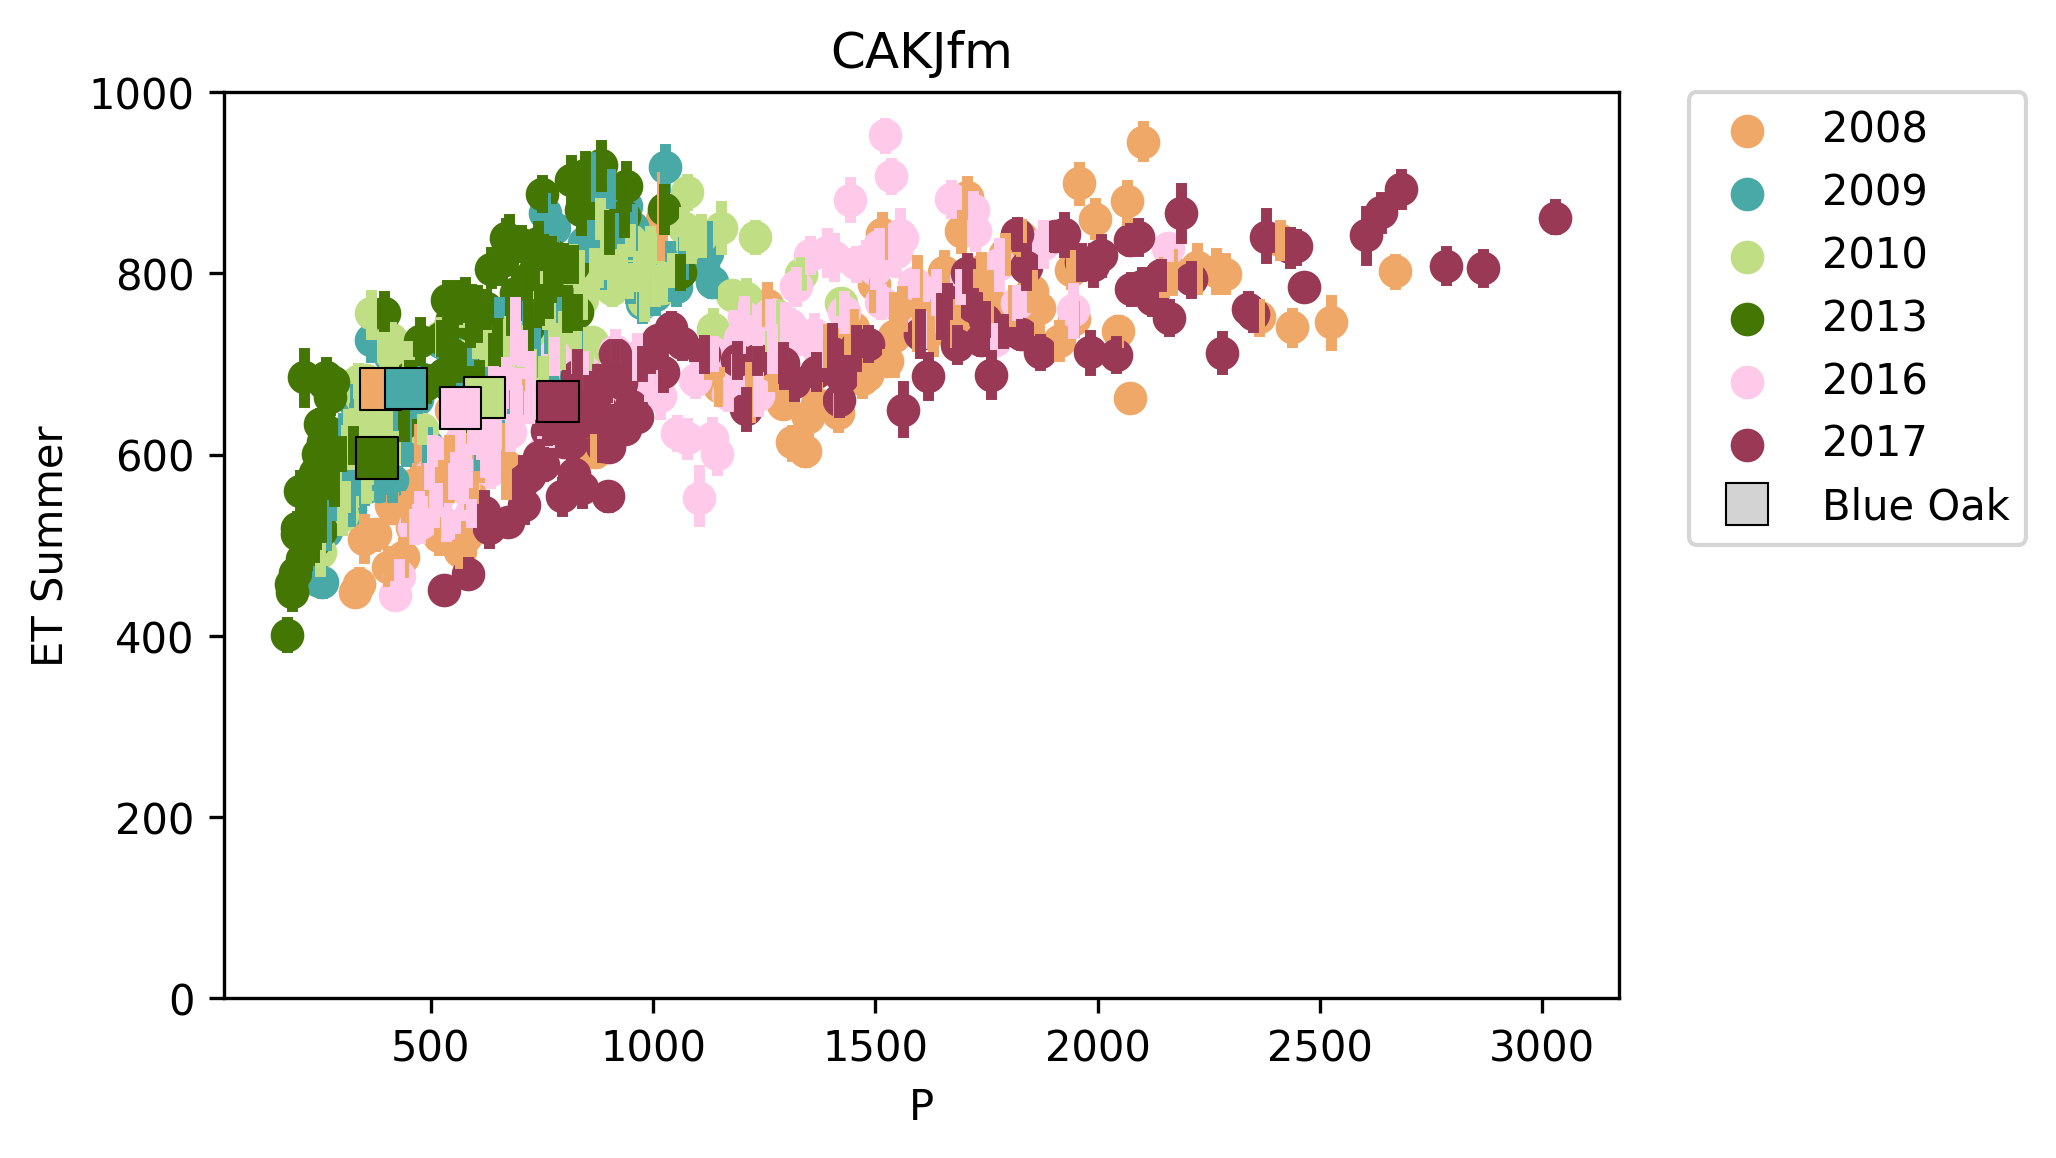

In [120]:
unit_regplot('CAKJfm', ['Blue Oak'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


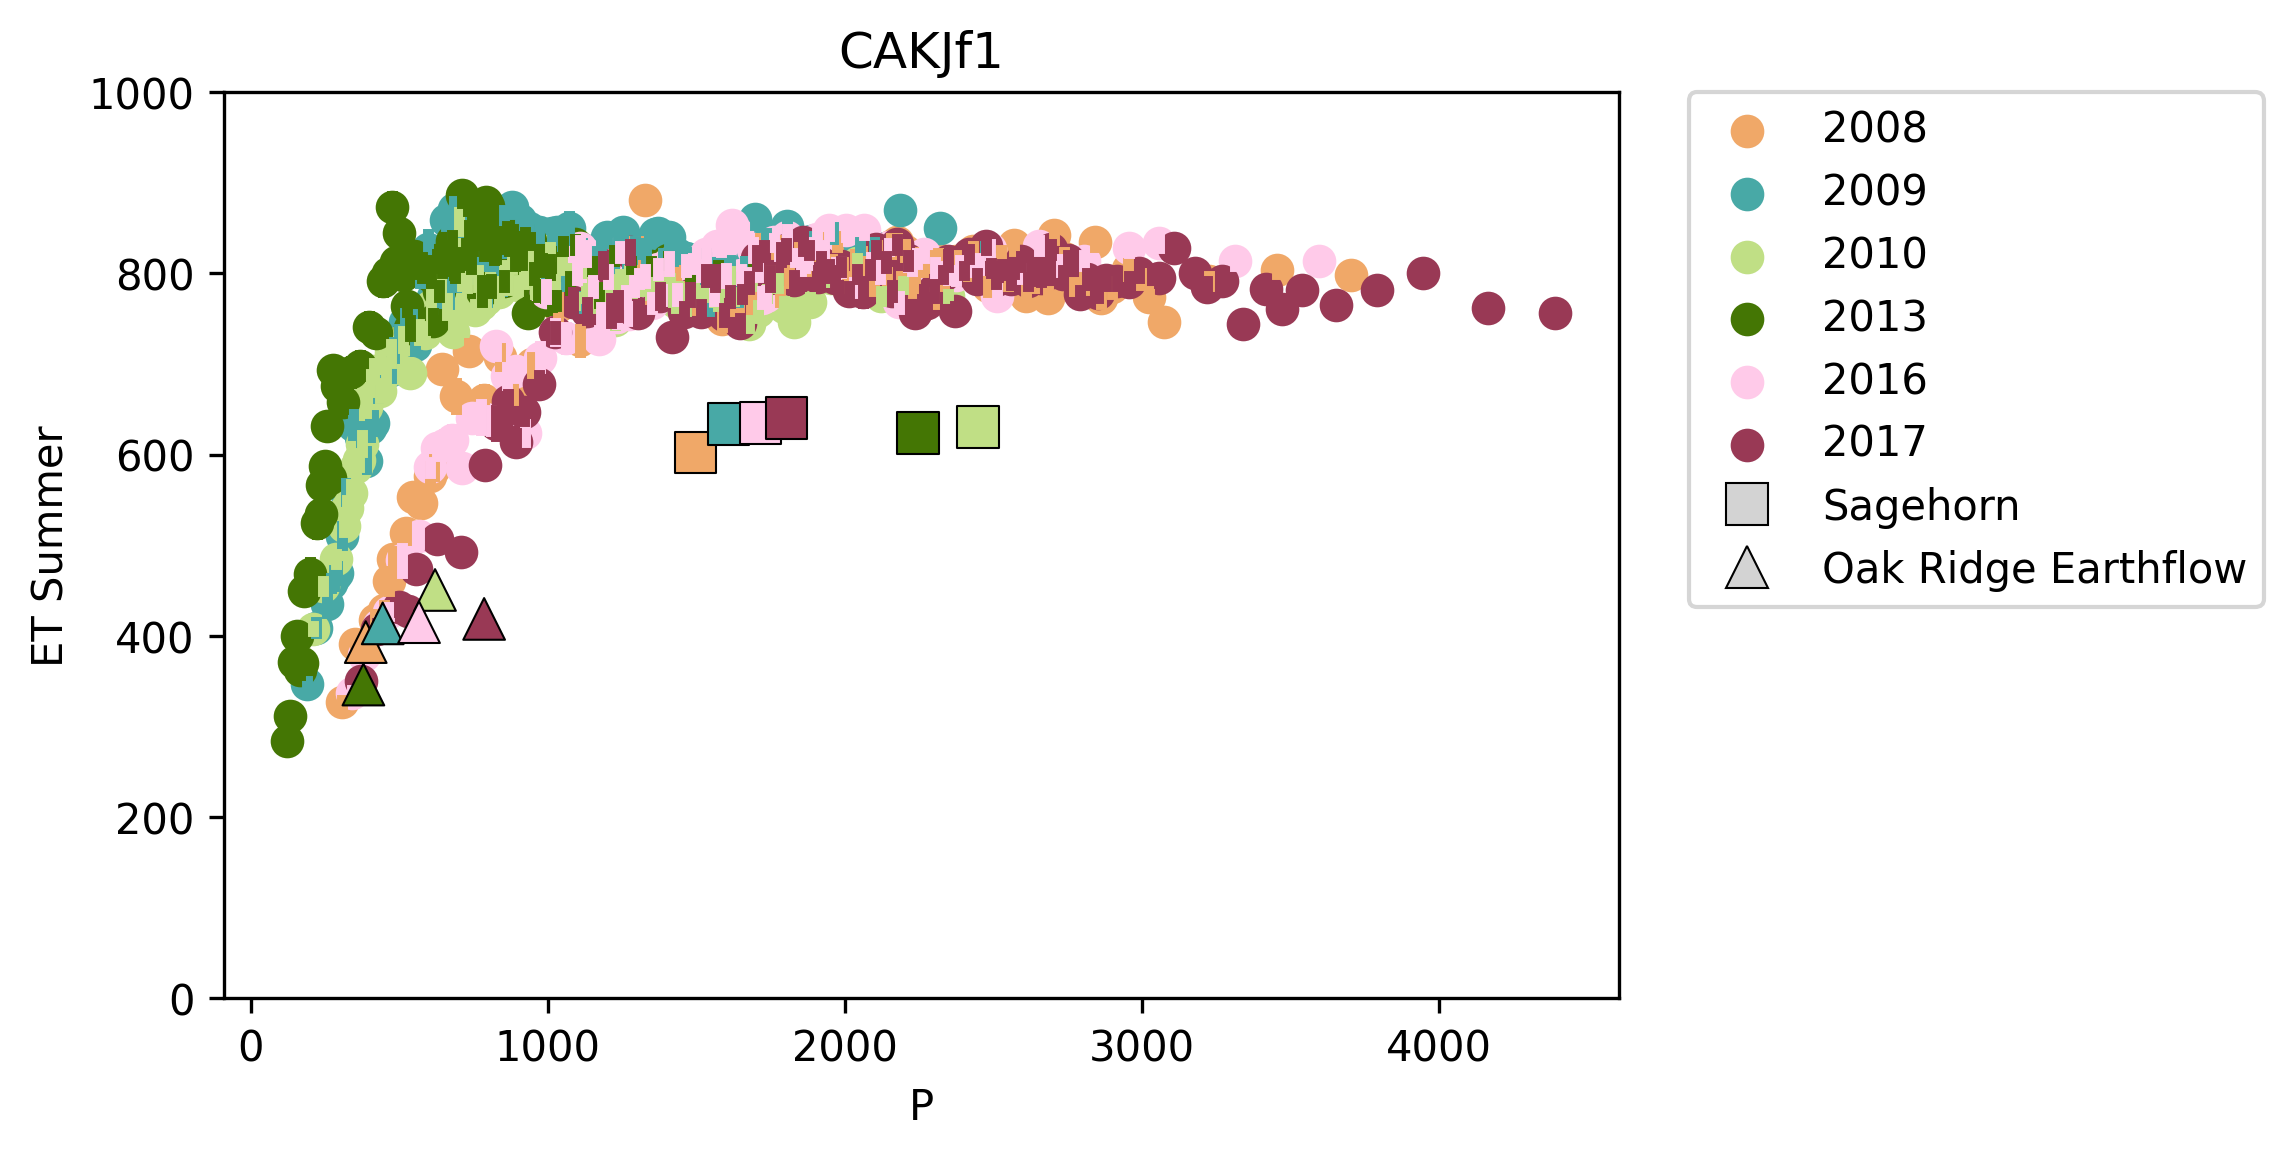

In [124]:
unit_regplot('CAKJf1', ['Sagehorn','Oak Ridge Earthflow'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


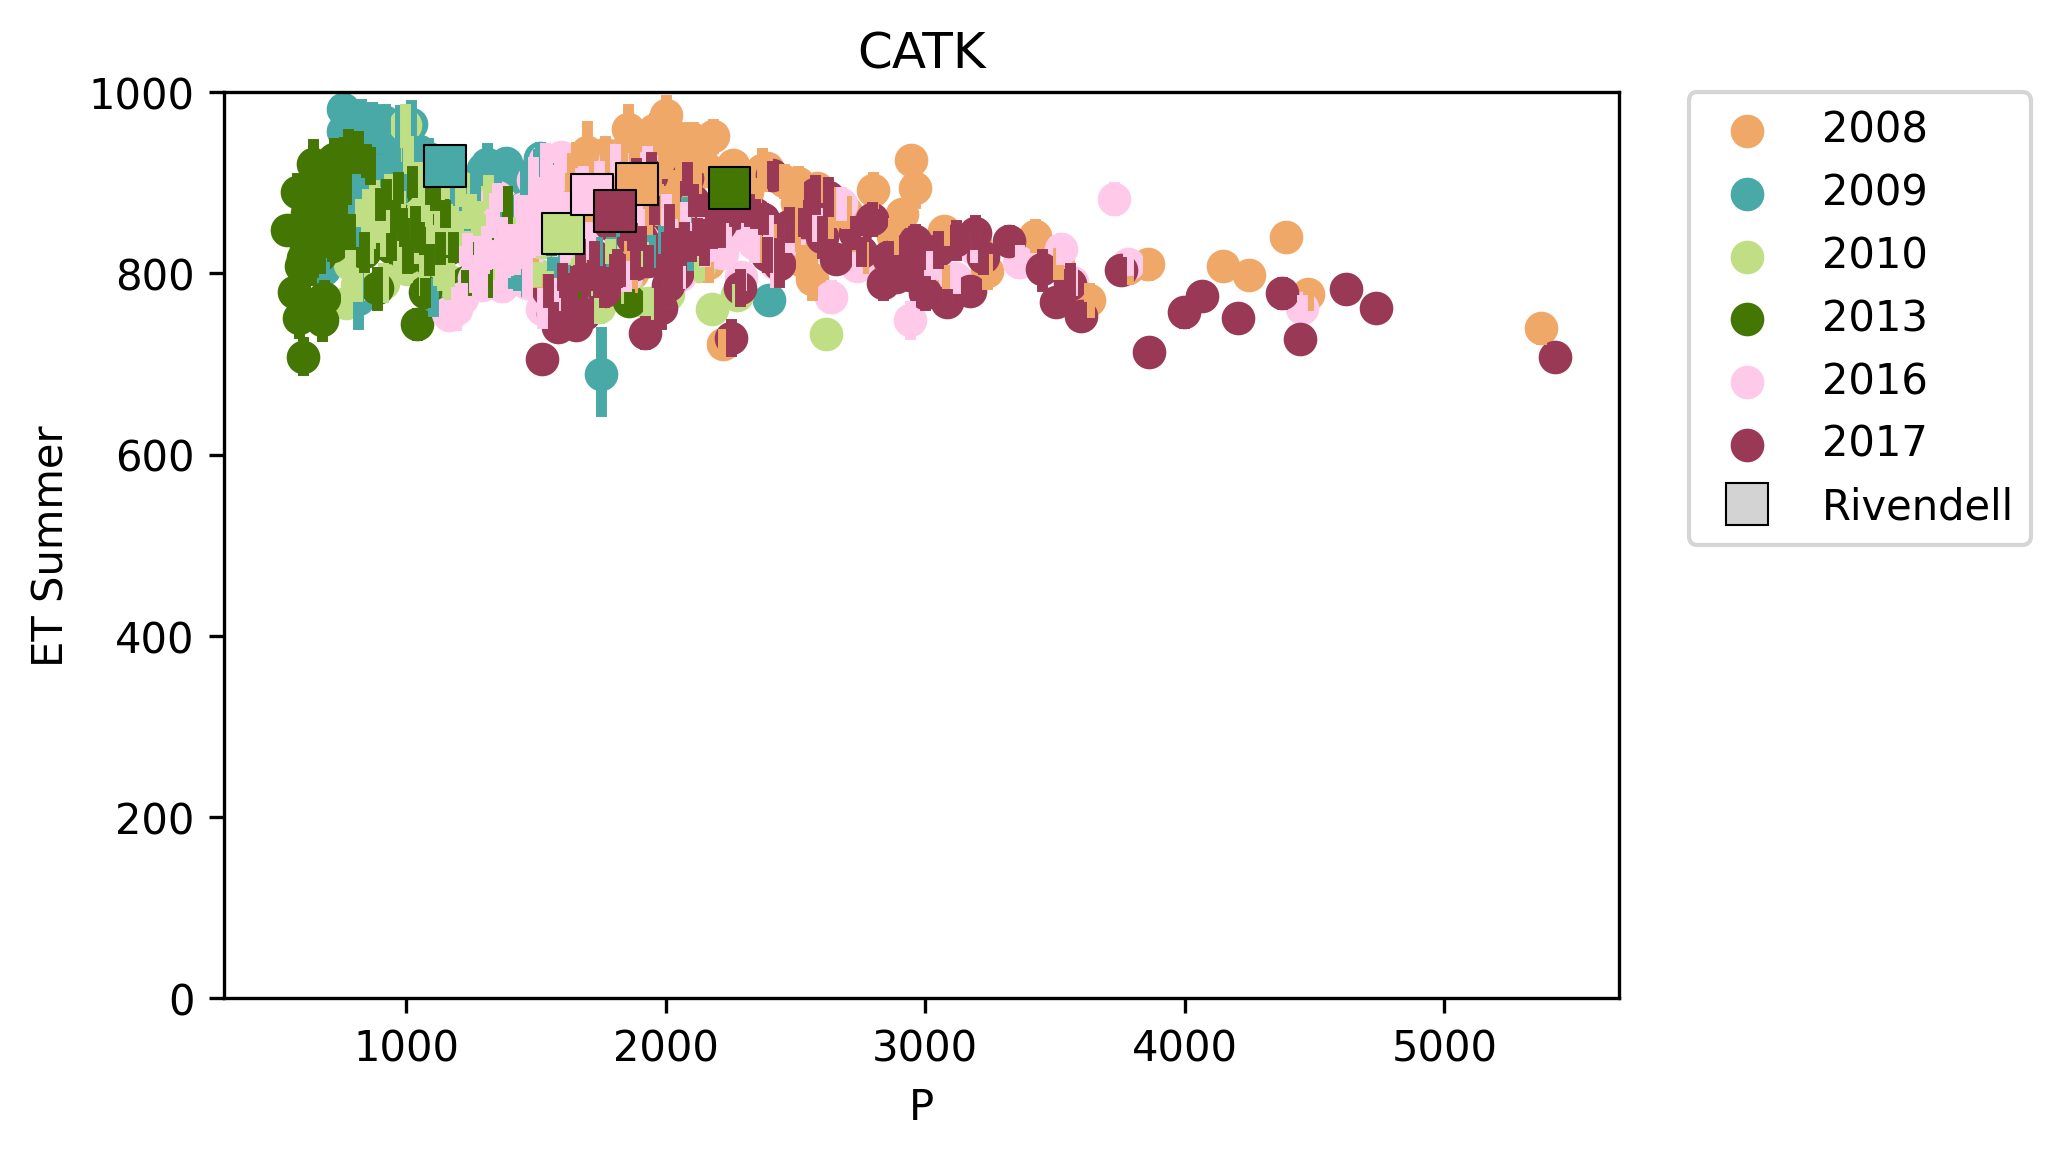

In [125]:
unit_regplot('CATK', ['Rivendell'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


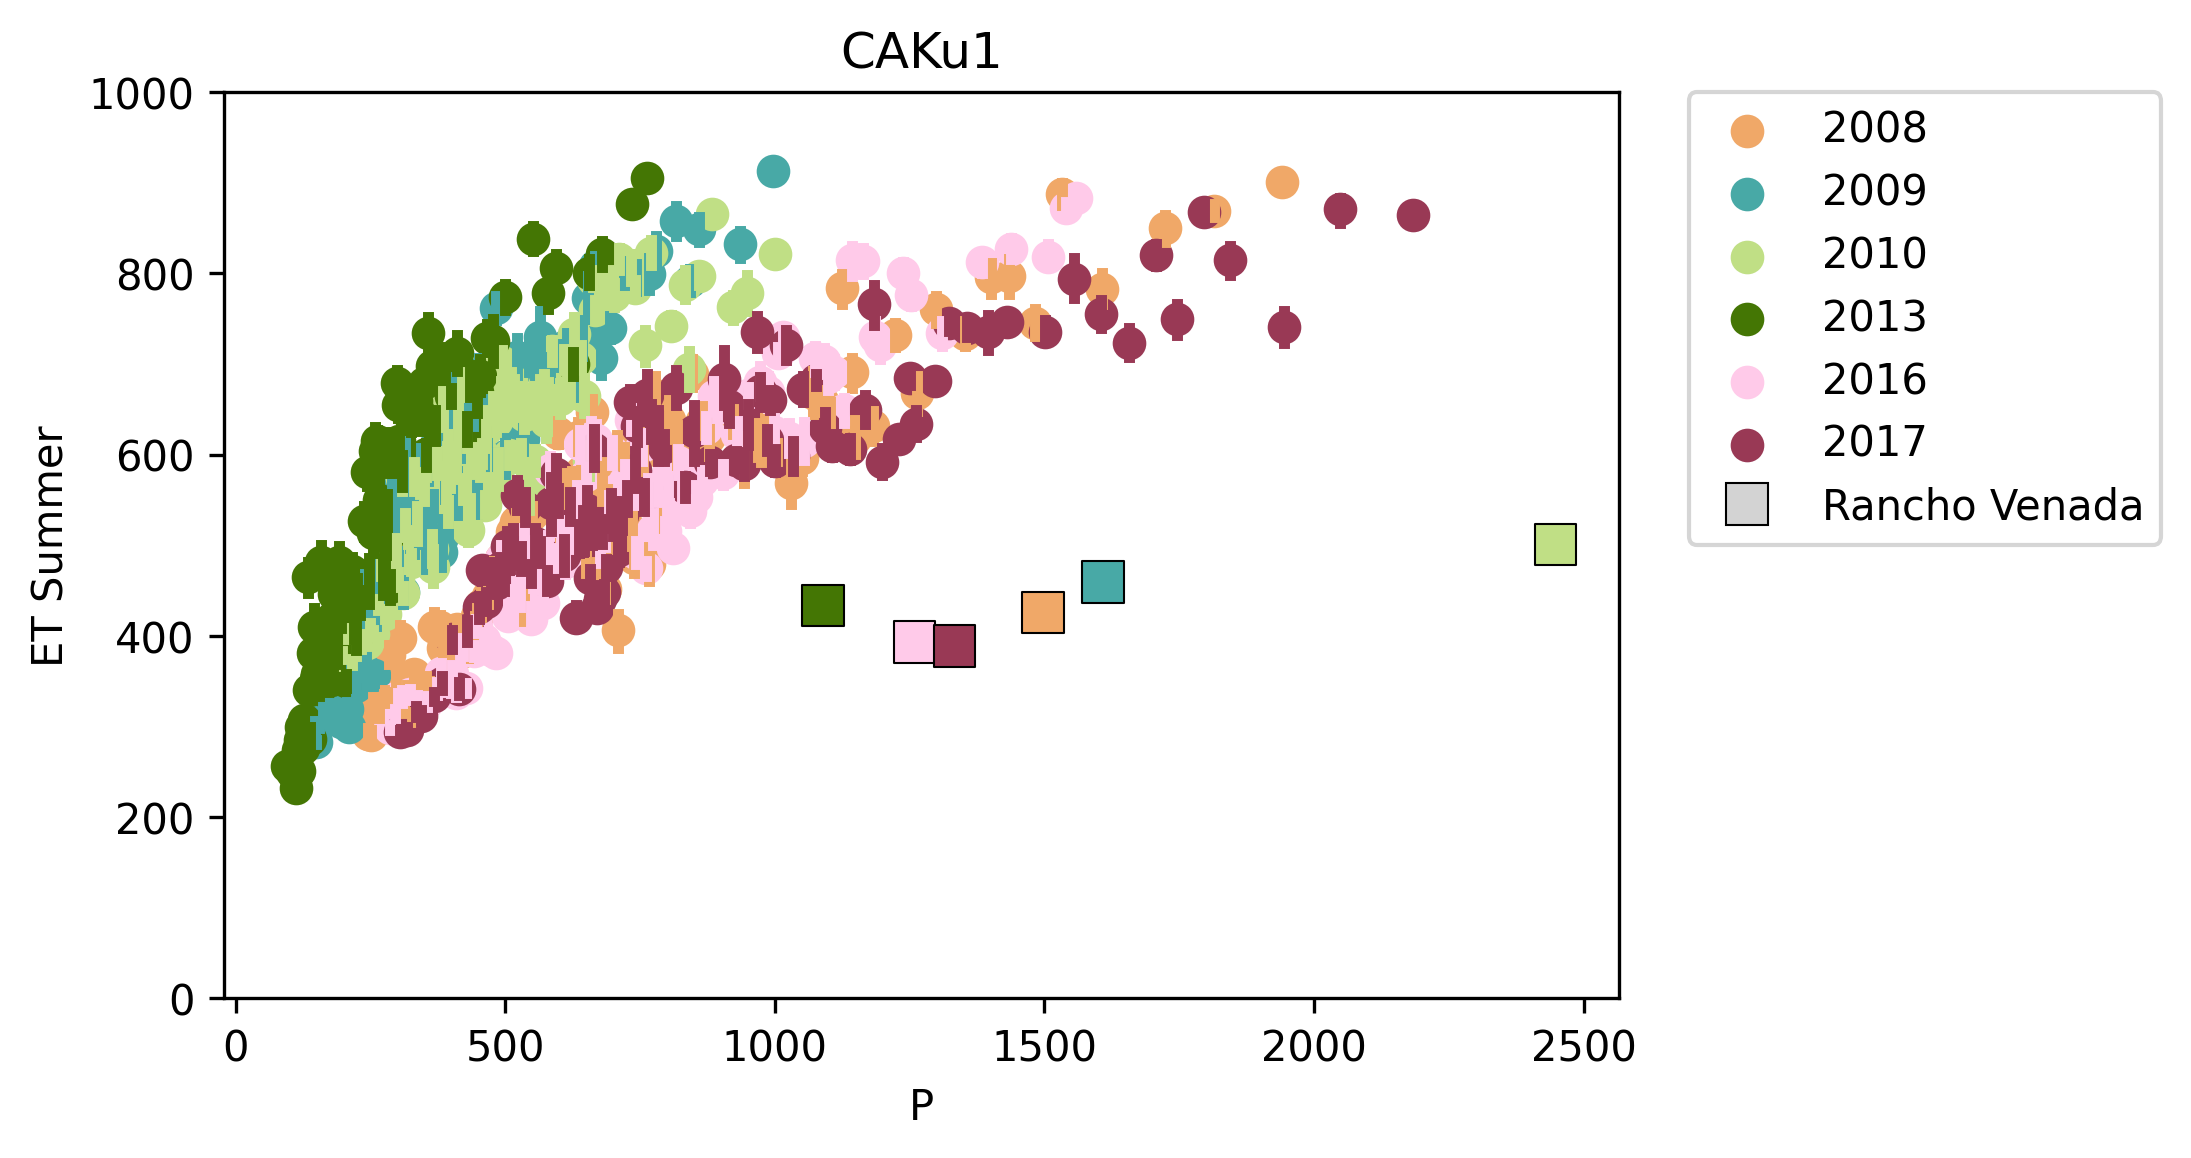

In [126]:
unit_regplot('CAKu1', ['Rancho Venada'])